In [1]:
import utils.datareader as datareader
import utils.visualizer as visualizer
from models.rnn import *

Parameters:

In [2]:
datafolder = 'C://Users//marku//Desktop//krafthack_files'

targets = [f'Bolt_{n+1}_Tensile' for n in range(6)]

# ML model parameters:
learning_rate = 3e-3 # optimizer
learning_rate_annealing = 0.1 # how much the learning rate is annealed every episode
episodes = 5 # how often it is iterated over the entire dataset
plotupdate = 5000 # at how many episodes the plot is updated

Read and scale datasets:

In [3]:
df, dfT = datareader.df_from_folder(datafolder)
df, dfT, scaler = datareader.normalize_input(df, dfT)


Make features:

In [4]:
features = dfT.columns

In [5]:
# here we generate training sets from the inputs:
dfT = df.iloc[int(3e5):].copy()
df = df.iloc[:int(3e5)].copy()

dfT_targets = dfT[targets]
dfT_features = dfT[features]
df_features = df[features]
df_targets = df[targets]

Split the features and the targets into slices that are read into GPU or CPU in sequence:

In [6]:
df_features_slices = slice_df(df_features)
df_targets_slices = slice_df(df_targets)

Set up neural network and associated utils:

In [7]:
net = Network(len(features), len(targets))
net.train() # starting in training mode
optim = torch.optim.Rprop(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [8]:

x, nans = make_tensor(df_features_slices[0], net.device)

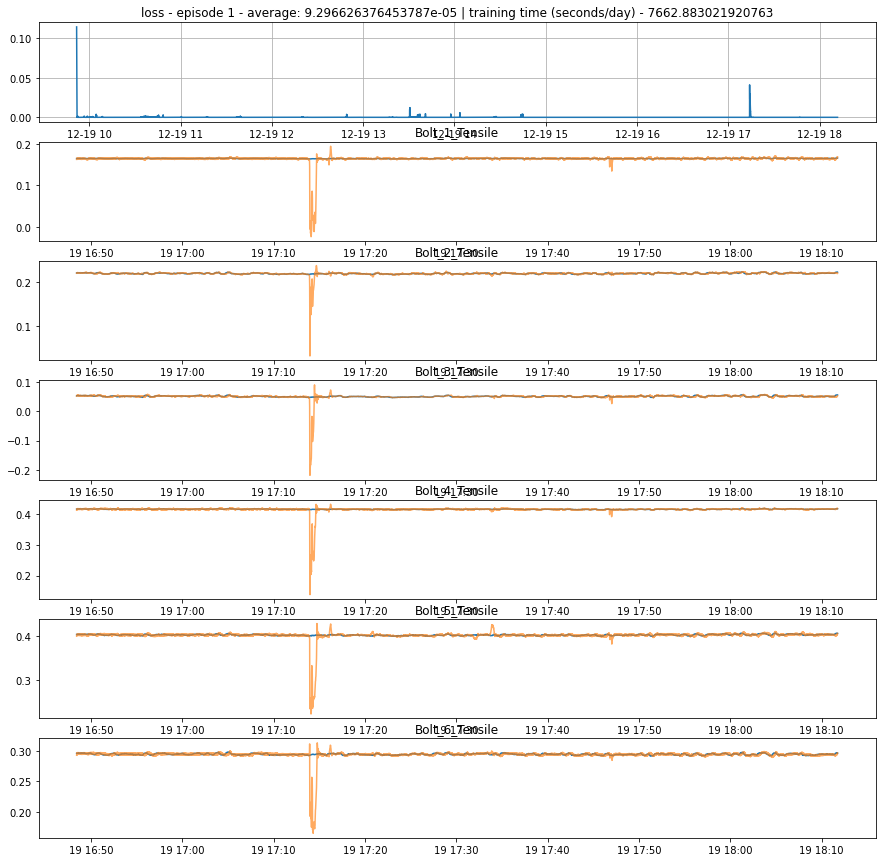

KeyboardInterrupt: 

In [9]:
import time 
for e in range(episodes):
    losshistory = []
    predictionhistory = []
    targethistory = []
    periods = []
    trainingtime = []
    hidden = None # initialized hidden state
    starttime = time.time()
    for slice_feature, slice_target in zip(df_features_slices, df_targets_slices):
        X, nans = make_tensor(slice_feature, net.device)
        Y, _ = make_tensor(slice_target, net.device)
        for (i, x), y, n in zip(enumerate(X), Y, nans):
            y_pred, hidden = net(x.reshape(1,-1), hidden)
            # only update the model if n is False:
            if n is False:
                # zero out gradients:
                net.zero_grad() 
                # calculate losses:
                loss = loss_fn(y_pred, y.reshape(1,-1))
                # backpropagation:
                loss.backward()
                optim.step()
                losshistory.append(loss.detach().cpu().numpy())
                predictionhistory.append(y_pred.reshape(-1).detach().cpu().numpy())
                targethistory.append(y.reshape(-1).detach().cpu().numpy())
                periods.append(slice_feature.index[i])
                trainingtime.append( (time.time()-starttime)/(i+1)) 
                # visualize:
                if i%plotupdate == 0:
                    visualizer.trainingplot(e+1, losshistory, predictionhistory, targethistory, periods, trainingtime, targets)
                
    # anneal learning rate:
    for g in optim.param_groups:
        g['lr'] = g['lr'] * (1 - learning_rate_annealing)
